<a href="https://colab.research.google.com/github/LeiyuanHuo/technical-documentation/blob/main/test_pset3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from keras import models
from keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/pset3_data/cleaned_data.csv')
factor = pd.read_csv('/content/drive/MyDrive/pset3_data/ff-factor.csv', names=['time', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF'])

Mounted at /content/drive


In [ ]:
print(data.head())
print(factor.head())

   index  stock_id  price    return  time_stamp
0      1     10001   6.50  0.019608    19890131
1      2     10001   6.75  0.038462    19890228
2      3     10001   6.75  0.000000    19890331
3      4     10001   7.25  0.074074    19890428
4      5     10001   7.00 -0.034483    19890531
     time  Mkt-RF   SMB   HML   RMW   CMA    RF
0  198901    6.10 -2.22  0.53 -0.86  0.17  0.55
1  198902   -2.25  2.66  0.88 -0.76  1.87  0.61
2  198903    1.57  0.75  0.48 -0.03  0.75  0.67
3  198904    4.33 -0.69 -1.47  0.78 -0.52  0.67
4  198905    3.35  0.00 -0.83  0.44 -0.02  0.79


In [ ]:
factor1 = factor[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].to_numpy()
RF = factor['RF'].to_numpy()

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_factor = factor1[0:241]
train_factor = scaler.fit_transform(train_factor)
test_factor = factor1[241:288]
test_factor = scaler.transform(test_factor)

In [ ]:
print(np.mean(train_factor, axis=0))
print(np.std(train_factor, axis=0))
print(np.mean(test_factor, axis=0))
print(np.std(test_factor, axis=0))

[ 2.94831011e-17 -1.47415505e-17  0.00000000e+00  1.75055913e-17
 -2.21123258e-17]
[1. 1. 1. 1. 1.]
[ 0.2611987   0.07729301 -0.02470434 -0.11479372  0.0024776 ]
[1.1304115  0.75318202 0.80100182 0.54771194 0.64936205]


In [ ]:
stocks = pd.unique(data['stock_id']).tolist()
print(stocks[:10])

[10001, 10002, 10025, 10026, 10032, 10065, 10104, 10107, 10138, 10145]


In [ ]:
stock = 10145
temp = data[data['stock_id'] == stock]['return'].to_numpy()
temp = temp * 100 - RF
train_temp = temp[0:241]
test_temp = temp[241:288]
print(temp.shape, train_temp.shape)

(288,) (241,)


In [ ]:
from keras import regularizers

In [ ]:
# network = models.Sequential()
# network.add(layers.Dense(units=30, activation='relu', 
#                          kernel_regularizer= regularizers.l2(.05), 
#                          input_shape=(train_factor.shape[1],)))
# network.add(layers.Dense(units=10, kernel_regularizer= regularizers.l2(.05), 
#                          activation='relu'))
# network.add(layers.Dropout(0.6))
# network.add(layers.Dense(units=5, activation='elu'))
# network.add(layers.Dropout(0.6))
# network.add(layers.Dense(units=1))
# network.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [ ]:
network = models.Sequential()
network.add(layers.Dense(units=20, activation='relu', 
                         kernel_regularizer= regularizers.l2(.05), 
                         input_shape=(train_factor.shape[1],)))
network.add(layers.Dense(units=10, kernel_regularizer= regularizers.l2(.05), 
                         activation='relu'))
network.add(layers.Dropout(0.6))
network.add(layers.Dense(units=1))
network.compile(loss='mse', optimizer='adam', metrics=['mse'])
# 0.25 R2, not much overfitting

In [ ]:
network = models.Sequential()
network.add(layers.Dense(units=20, activation='relu', 
                         kernel_regularizer= regularizers.l2(.06), 
                         input_shape=(train_factor.shape[1],)))
network.add(layers.Dense(units=5, kernel_regularizer= regularizers.l2(.06), 
                         activation='relu'))
network.add(layers.Dropout(0.6))
network.add(layers.Dense(units=1))
network.compile(loss='mse', optimizer='adam', metrics=['mse'])
# a bit overfitting, but R2 can be around 0.3, drops later in the epoch
# increased regularization a bit, dropping is less severe
# decreased second layer neuron units from 10 to 5, R2 did not worsen

In [ ]:
network = models.Sequential()
network.add(layers.Dense(units=10, activation='relu', 
                         kernel_regularizer= regularizers.l2(.06), 
                         input_shape=(train_factor.shape[1],)))
network.add(layers.Dropout(0.6))
network.add(layers.Dense(units=1))
network.compile(loss='mse', optimizer='adam', metrics=['mse'])
# underfitting, but test set perform quite well, try a different stock

In [ ]:
history = network.fit(train_factor, train_temp, epochs=500, verbose=0, 
                      validation_data=(test_factor, test_temp))

In [ ]:
predicted_target = network.predict(test_factor)
predicted_target[0:5]

array([[-13.840307 ],
       [  4.2752285],
       [  4.660074 ],
       [  3.4169762],
       [ -0.6110294]], dtype=float32)

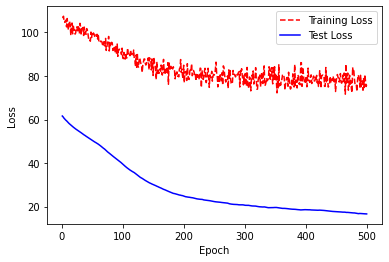

In [ ]:
# visualize loss during training history
import matplotlib.pyplot as plt
train_loss = history.history['loss']
test_loss = history.history['val_loss']
epoch_count = range(1, len(train_loss) + 1)
plt.plot(epoch_count, train_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

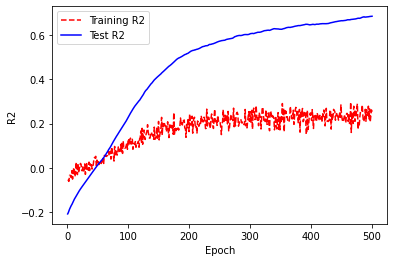

In [ ]:
train_yvar = np.var(train_temp)
test_yvar = np.var(test_temp)
train_R2 = 1 - history.history['mse'] / train_yvar
test_R2 = 1 - history.history['val_mse'] / test_yvar
plt.plot(epoch_count, train_R2, 'r--')
plt.plot(epoch_count, test_R2, 'b-')
plt.legend(['Training R2', 'Test R2'])
plt.xlabel('Epoch')
plt.ylabel('R2')
plt.show()

In [ ]:
for stock in stocks:
  temp = data[data['stock_id'] == stock]['return'].to_numpy()
  temp = temp * 100 - RF
  train_temp = temp[0:241]
  test_temp = temp[241:288]

  network = models.Sequential()
  network.add(layers.Dense(units=10, activation='relu', 
                          kernel_regularizer= regularizers.l2(.06), 
                          input_shape=(train_factor.shape[1],)))
  network.add(layers.Dropout(0.6))
  network.add(layers.Dense(units=1))
  network.compile(loss='mse', optimizer='adam', metrics=['mse'])

  history = network.fit(train_factor, train_temp, epochs=500, verbose=0, 
                      validation_data=(test_factor, test_temp))
  
  train_yvar = np.var(train_temp)
  test_yvar = np.var(test_temp)
  train_R2 = 1 - history.history['mse'] / train_yvar
  test_R2 = 1 - history.history['val_mse'] / test_yvar
